In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.models import Model
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.layers import Conv1D, MaxPool1D, BatchNormalization
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras.utils import plot_model

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
EMBEDDING_FILE = './data/embeddings/glove.840B.300d/glove.840B.300d.txt'
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')

In [3]:
X_train = train["question_text"].fillna("fillna").values
y_train = train["target"].values
X_test = test["question_text"].fillna("fillna").values

max_features = 40000
maxlen = 70
embed_size = 300

threshold = 0.35

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train) + list(X_test))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [7]:
def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding='utf-8', errors='ignore'))

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [8]:
class F1Evaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            y_pred = (y_pred > threshold).astype(int)
            score = f1_score(self.y_val, y_pred)
            print("\n F1 Score - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [15]:
filter_sizes = [1,2,3,5]
num_filters = 42

def get_model1():    
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
#    x = SpatialDropout1D(0.4)(x)
    x = Reshape((maxlen, embed_size, 1))(x)
    
    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embed_size),
                                 kernel_initializer='he_normal', activation='tanh')(x)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embed_size),
                                 kernel_initializer='he_normal', activation='tanh')(x)
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embed_size), 
                                 kernel_initializer='he_normal', activation='tanh')(x)
    conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[3], embed_size),
                                 kernel_initializer='he_normal', activation='tanh')(x)
    
    maxpool_0 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1))(conv_0)
    maxpool_1 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1))(conv_1)
    maxpool_2 = MaxPool2D(pool_size=(maxlen - filter_sizes[2] + 1, 1))(conv_2)
    maxpool_3 = MaxPool2D(pool_size=(maxlen - filter_sizes[3] + 1, 1))(conv_3)
        
    z = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2, maxpool_3])   
    z = Flatten()(z)
    z = Dropout(0.1)(z)
        
    outp = Dense(1, activation="sigmoid")(z)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [16]:
def getTrainingPlots(history, name):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    plt.savefig(str(name)+"_accuracy.png")

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    plt.savefig(str(name)+"_loss.png")

In [19]:
model = get_model1()
plot_model(model, to_file='model1.png')

In [25]:
import json
with open('hist1.json', 'w') as f:
    json.dump(hist.history, f)

In [34]:
batch_size = 256
epochs = 5

X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.95,
                                              random_state=233)
F1_Score = F1Evaluation(validation_data=(X_val, y_val), interval=1)

hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs,
                 validation_data=(X_val, y_val),
                 callbacks=[F1_Score], verbose=1)
model.save("model1.h5")

Train on 1240815 samples, validate on 65307 samples
Epoch 1/5
1240815/1240815 [==============================] - 2095s 2ms/step - loss: 0.0739 - acc: 0.9712 - val_loss: 0.1179 - val_acc: 0.9576

 F1 Score - epoch: 1 - score: 0.626194 

Epoch 2/5
1240815/1240815 [==============================] - 2069s 2ms/step - loss: 0.0674 - acc: 0.9741 - val_loss: 0.1198 - val_acc: 0.9587

 F1 Score - epoch: 2 - score: 0.641019 

Epoch 3/5
1240815/1240815 [==============================] - 2063s 2ms/step - loss: 0.0612 - acc: 0.9766 - val_loss: 0.1289 - val_acc: 0.9568

 F1 Score - epoch: 3 - score: 0.623461 

Epoch 4/5
1240815/1240815 [==============================] - 2090s 2ms/step - loss: 0.0556 - acc: 0.9789 - val_loss: 0.1368 - val_acc: 0.9560

 F1 Score - epoch: 4 - score: 0.604626 

Epoch 5/5
1240815/1240815 [==============================] - 2121s 2ms/step - loss: 0.0507 - acc: 0.9809 - val_loss: 0.1410 - val_acc: 0.9566

 F1 Score - epoch: 5 - score: 0.619150 



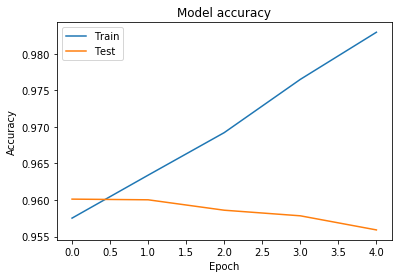

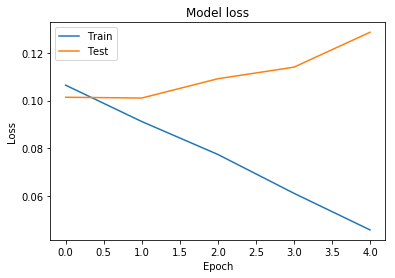

<Figure size 432x288 with 0 Axes>

In [28]:
getTrainingPlots(hist, "model1")

In [29]:
def get_model2():    
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.4)(x)
    
    conv_0 = Conv1D(num_filters, kernel_size=(filter_sizes[0]),
                                 kernel_initializer='he_normal', activation='elu')(x)
    conv_1 = Conv1D(num_filters, kernel_size=(filter_sizes[1]),
                                 kernel_initializer='he_normal', activation='elu')(x)
    conv_2 = Conv1D(num_filters, kernel_size=(filter_sizes[2]), 
                                 kernel_initializer='he_normal', activation='elu')(x)
    conv_3 = Conv1D(num_filters, kernel_size=(filter_sizes[3]),
                                 kernel_initializer='he_normal', activation='elu')(x)
    
    maxpool_0 = MaxPool1D(pool_size=(maxlen - filter_sizes[0] + 1))(conv_0)
    maxpool_1 = MaxPool1D(pool_size=(maxlen - filter_sizes[1] + 1))(conv_1)
    maxpool_2 = MaxPool1D(pool_size=(maxlen - filter_sizes[2] + 1))(conv_2)
    maxpool_3 = MaxPool1D(pool_size=(maxlen - filter_sizes[3] + 1))(conv_3)
        
    z = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2, maxpool_3])   
    z = Flatten()(z)
    z = BatchNormalization()(z)
        
    outp = Dense(1, activation="sigmoid")(z)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [30]:
model = get_model2()
plot_model(model, to_file='model2.png')

In [32]:
batch_size = 256
epochs = 5

X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.95,
                                              random_state=233)
F1_Score = F1Evaluation(validation_data=(X_val, y_val), interval=1)

hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs,
                 validation_data=(X_val, y_val),
                 callbacks=[F1_Score], verbose=1)
model.save("model2.h5")

Train on 1240815 samples, validate on 65307 samples
Epoch 1/5
1240815/1240815 [==============================] - 2057s 2ms/step - loss: 0.1279 - acc: 0.9504 - val_loss: 0.1063 - val_acc: 0.9584

 F1 Score - epoch: 1 - score: 0.650466 

Epoch 2/5
1240815/1240815 [==============================] - 2102s 2ms/step - loss: 0.1034 - acc: 0.9590 - val_loss: 0.1040 - val_acc: 0.9593

 F1 Score - epoch: 2 - score: 0.656493 

Epoch 3/5
1240815/1240815 [==============================] - 2069s 2ms/step - loss: 0.0957 - acc: 0.9619 - val_loss: 0.1039 - val_acc: 0.9596

 F1 Score - epoch: 3 - score: 0.657734 

Epoch 4/5
1240815/1240815 [==============================] - 2041s 2ms/step - loss: 0.0886 - acc: 0.9649 - val_loss: 0.1064 - val_acc: 0.9585

 F1 Score - epoch: 4 - score: 0.642236 

Epoch 5/5
1240815/1240815 [==============================] - 1982s 2ms/step - loss: 0.0812 - acc: 0.9682 - val_loss: 0.1135 - val_acc: 0.9580

 F1 Score - epoch: 5 - score: 0.631246 



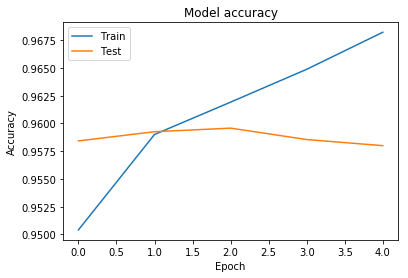

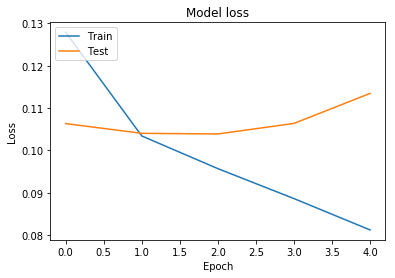

<Figure size 432x288 with 0 Axes>

In [33]:
getTrainingPlots(hist, "model2")

In [41]:
def getF1Plots(f1Scores, name):
    # Plot training & validation accuracy values
    plt.plot(f1Scores, 'ko-')
    plt.title(str(name) + " F1 Scores")
    plt.ylabel('F1 score')
    plt.xlabel('Epoch')
    plt.savefig(str(name)+"_results.png")

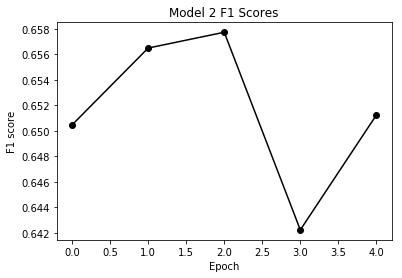

In [42]:
getF1Plots([0.650466, 0.656493, 0.657734, 0.642236, 0.651246], "Model 2")

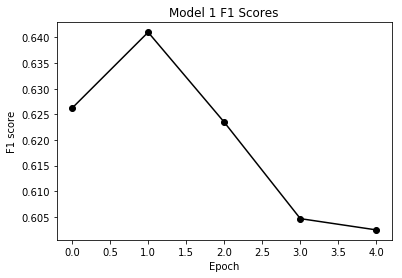

In [43]:
getF1Plots([0.626194, 0.641019, 0.623461, 0.604626, 0.602424], "Model 1")